# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, classification_report, log_loss, mean_squared_error
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer



In [ ]:
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import operator

nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import numpy as np
import scipy
from scipy.sparse import hstack

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,pid,sentence1,sentence2,label
0,4665,do you accept broadband bills,Broadband bill,1
1,26465,I am getting better fare for this flight,Check flight rate,0
2,57679,Flight from delhi to srinagar,check price for flight from mumbai to pune,1
3,22043,Availability of food,food available for guest,1
4,6522,This is my ID only,Can't find order ID.,0




#EDA


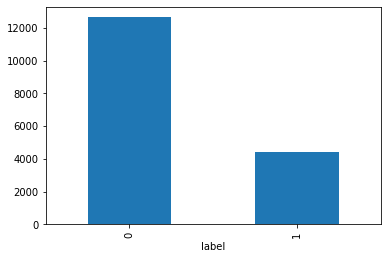

In [ ]:
df.groupby("label")['pid'].count().plot.bar()

In [ ]:
df.label.value_counts()

0    12650
1     4394
Name: label, dtype: int64

In [ ]:
print('~> Total number of sentence pairs for training:\n   {}'.format(len(df)))

In [ ]:
print('~> sentence pairs are not Similar (label = 0):\n   {}%'.format(100 - round(df['label'].mean()*100, 2)))
print('\n~> sentence pairs are Similar (label = 1):\n   {}%'.format(round(df['label'].mean()*100, 2)))

~> sentence pairs are not Similar (label = 0):
   74.22%

~> sentence pairs are Similar (label = 1):
   25.78%


array(<17044x2490 sparse matrix of type '<class 'numpy.int64'>'
	with 50130 stored elements in Compressed Sparse Row format>, dtype=object)

##number of words

In [ ]:
data2 = pd.read_csv('data2.csv')

In [ ]:
data2.text2 = data2.text2.apply(lambda row: str(row))
all_text = data2.text2.tolist()


In [ ]:
BoW = pd.Series(all_text).apply(lambda i: i.lower())
BoW = list(BoW)
len(BoW)

17044

In [ ]:
BoW = [word_tokenize(x) for x in BoW]
BoW = [item for sublist in BoW for item in sublist]
# BoW = [x for x in BoW if x not in custom]
# BoW = [lemmatizer.lemmatize(y) for y in BoW]

len(BoW)

56083

In [ ]:
BoW[:10]

['broadband',
 'bill',
 'check',
 'flight',
 'rate',
 'check',
 'price',
 'flight',
 'mumbai',
 'pune']

In [ ]:
BoW_dict = dict(Counter(BoW))


In [ ]:
sorted_bag = sorted(BoW_dict.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
sorted_bag[:12]

[('flight', 2510),
 ('want', 2189),
 ('ticket', 1392),
 ('not', 1308),
 ('reminder', 1276),
 ('book', 1032),
 ('need', 608),
 ('cashback', 595),
 ('get', 581),
 ('id', 537),
 ('offer', 535),
 ('please', 530)]

In [ ]:
bagdf = pd.DataFrame(sorted_bag,columns= ['word','count'])

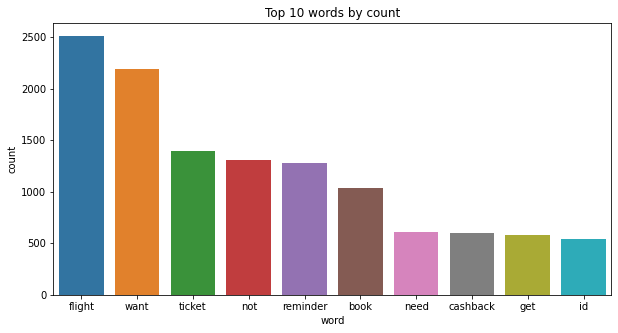

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Top 10 words by count')
sns.barplot(bagdf['word'][:10],bagdf['count'][:10])

Most people use the chat bot for booking flight tickets or getting related information.

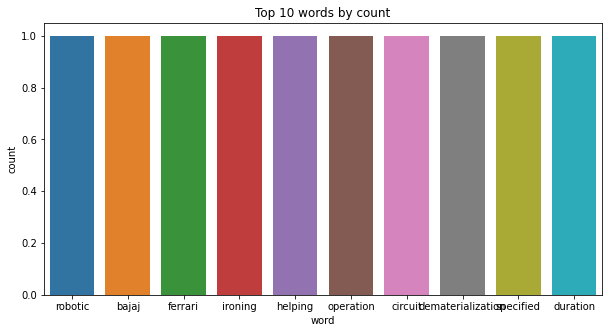

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Top 10 words by count')
sns.barplot(bagdf['word'][-10:],bagdf['count'][-10:])

<h3> 3.2.2 Number of unique questions </h3>

In [ ]:
qids = pd.Series(df['pid'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique sentences are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique sentences that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single sentences is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique sentences are: 17044

Number of unique sentences that appear more than one time: 0 (0.0%)

Max number of times a single sentences is repeated: 1



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


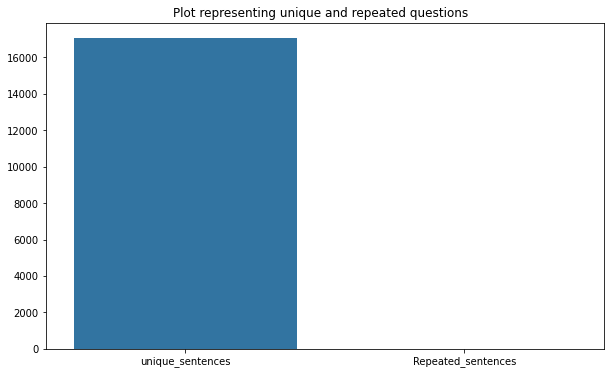

In [ ]:
x = ["unique_sentences" , "Repeated_sentences"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3> 3.2.5 Checking for NULL values </h3>

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [pid, sentence1, sentence2, label]
Index: []


In [ ]:
df.isnull().sum()

pid          0
sentence1    0
sentence2    0
label        0
dtype: int64

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____s1len____ = Length of q1
 - ____s2len____ = Length of q2
 - ____s1_n_words____ = Number of words in sentence 1
 - ____s2_n_words____ = Number of words in sentence 2
 - ____word_Common____ = (Number of common unique words in sentence 1 and sentence 2)
 - ____word_Total____ =(Total num of words in sentence 1 + Total num of words in sentence 2)
 - ____word_share____ = (word_common)/(word_Total)
 

# Splitting data into Train , Test in 80% and 20%  ratio before feature extraction to avoid data leakage

In [ ]:
y = df['label']
X = df

In [ ]:
X.head()

,pid,sentence1,sentence2,label
0,4665,do you accept broadband bills,Broadband bill,1
1,26465,I am getting better fare for this flight,Check flight rate,0
2,57679,Flight from delhi to srinagar,check price for flight from mumbai to pune,1
3,22043,Availability of food,food available for guest,1
4,6522,This is my ID only,Can't find order ID.,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

In [ ]:
#we need to convert all quiestions into string data type
#Training data---------------------------------------------------------------
X_train['sentence1'] = X_train['sentence1'].apply(lambda row: str(row))
X_train['sentence2'] = X_train['sentence2'].apply(lambda row: str(row))
#Test data-------------------------------------------------------------------
X_test['sentence1'] = X_test['sentence1'].apply(lambda row: str(row))
X_test['sentence2'] = X_test['sentence2'].apply(lambda row: str(row))

In [ ]:
print('Training data:' ,X_train.shape, y_train.shape)
print('Test data:    ' ,X_test.shape, y_test.shape)

Training data: (13635, 4) (13635,)
Test data:     (3409, 4) (3409,)


In [ ]:
def ques_len(sentence1,sentence2,df):
    #length of sentences
    df['q1len'] = df['sentence1'].str.len() 
    df['q2len'] = df['sentence2'].str.len()

def nwords_ques(sentence1,sentence2,df):
    #number of words in sentences
    df['q1_n_words'] = df['sentence1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['sentence2'].apply(lambda row: len(row.split(" ")))
    
def normalized_word_Common(row):
    #total unique words in both sentence
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    #total number of words
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
    
def normalized_word_share(row):
    #(word_common)/(word_Total)
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

# Basic Feature Extraction for X_train

In [ ]:

ques_len(X_train['sentence1'],X_train['sentence2'],X_train)#length of sentences
nwords_ques(X_train['sentence1'],X_train['sentence2'],X_train)#number of words in sentences
X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1)#total unique words in both sentence
X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1)#total number of words
X_train['word_share'] = X_train.apply(normalized_word_share, axis=1)#(word_common)/(word_Total)
X_train.to_csv('Xtrain_fe_without_preprocessing_train.csv',index= False)
X_train.head()

,pid,sentence1,sentence2,label,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
14859,33379,I had a hard time changing my ticket,I had a hard time booking,0,36,25,8,6,5.0,14.0,0.357143
13204,64330,I want to book bus tickets for Diwali,bus,0,37,3,8,1,1.0,9.0,0.111111
4157,14110,how much is the premium for Total Secure,What will be the premium for Total Secure,1,40,41,8,8,5.0,16.0,0.312500
3824,17949,add new savings bank account,How many savings bank account I can link with ...,0,28,65,5,12,3.0,17.0,0.176471
12220,64230,status of address change,address change status,0,24,21,4,3,3.0,7.0,0.428571


In [ ]:
X_train[['sentence1','sentence2']][X_train['word_share']>=0.5]

,sentence1,sentence2
3688,modification Reminder to Call,Reminder to Call Modification
9336,modification medicine reminder,Medicine Reminder Modification
12015,Tell me more about HDFC Life Easy Health,Tell me more about HDFC Life Easy Health
9434,Muje cash back nahi mila,Muje cash back nahi mila
2785,Cash back is not come in my wallet,Cash back is not come in my wallet
10408,I would like to cancel my daily horoscope,I would like to cancel my Daily Horoscope


# Basic Feature Extraction for X_test

In [ ]:

ques_len(X_test['sentence1'],X_test['sentence2'],X_test)#length of sentences
nwords_ques(X_test['sentence1'],X_test['sentence2'],X_test)#number of words in sentences
X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1)#total unique words in both sentence
X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1)#total number of words
X_test['word_share'] = X_test.apply(normalized_word_share, axis=1)#(word_common)/(word_Total)
X_test.to_csv('Xtest_fe_without_preprocessing_test.csv',index= False)
X_test.head()

,pid,sentence1,sentence2,label,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
12694,43637,Please send your pic,Give me your pic,1,20,16,4,4,2.0,8.0,0.250000
4796,4209,Please help me with flight booking,want to purchase Flight Tickets,0,34,31,6,5,1.0,11.0,0.090909
5739,18204,like to buy Flight Tickets,I want the boarding pass for my flight,0,26,38,5,8,1.0,13.0,0.076923
7447,10605,What are the benefits of Margin funding?,How does margin funding work?,0,40,29,7,5,1.0,12.0,0.083333
5182,50198,My RM is not reachable,not RM,1,22,6,5,2,2.0,7.0,0.285714


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- are some sentences have only one single words?

In [ ]:
print ("Minimum length of the sentences in sentence1 : " , min(X_train['q1_n_words']))

print ("Minimum length of the sentences in sentence2 : " , min(X_train['q2_n_words']))

print ("Number of sentences with minimum length [sentence1] :", X_train[X_train['q1_n_words']== 1].shape[0])
print ("Number of sentences with minimum length [sentence2] :", X_train[X_train['q2_n_words']== 1].shape[0])

Minimum length of the sentences in sentence1 :  1
Minimum length of the sentences in sentence2 :  1
Number of sentences with minimum length [sentence1] : 291
Number of sentences with minimum length [sentence2] : 215


In [ ]:
X_train[['sentence1','sentence2','label']][X_train['q1_n_words']==1]

,sentence1,sentence2,label
5081,No,No number,0
4547,Working,Didnt work,0
654,Benefits,total secure plus benefits,0
9999,Bites,Regular Bites,0
9337,Charges,How much is the charge?,0
...,...,...,...
13518,Coupon,Cashback not yet received,0
6665,hotels,Can you show me the hotel near me,0
1306,22,Between 5 lacs to 10 lacs,0
4635,Indian,Indian Resident,0


In [ ]:
#NOTICE SOME ARE KG (kilograms)

<h4> 3.3.1.1 Feature: word_share </h4>

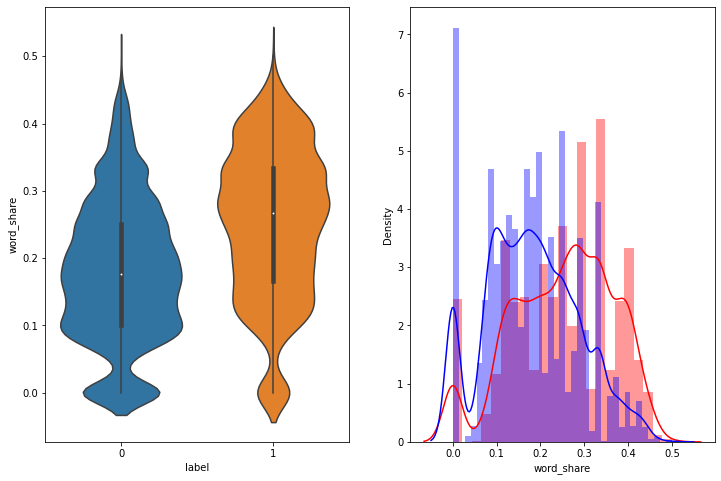

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'label', y = 'word_share', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['label'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['label'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> 3.3.1.2 Feature: word_Common </h4>

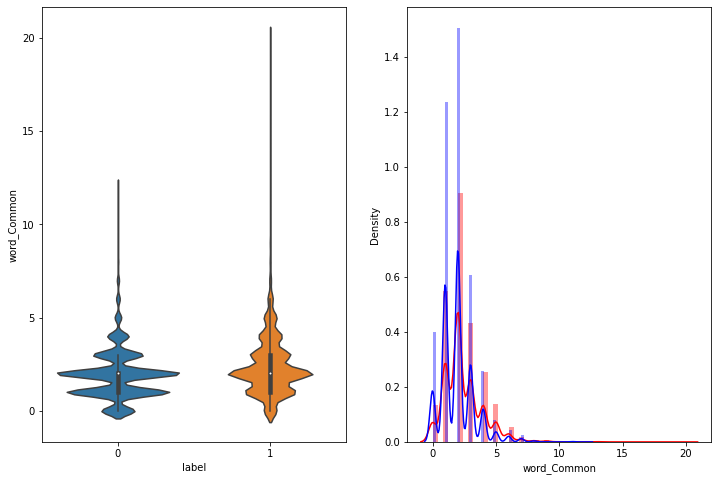

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'label', y = 'word_Common', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['label'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['label'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

# <h2> 3.4 Preprocessing of Text </h2>

 - Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [ ]:
X_train.head()

,pid,sentence1,sentence2,label,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
542,9347,I want to book flight tickets for New Year,Want to book my seat,0,42,20,9,5,3.0,14.0,0.214286
4984,45269,Any other option,Some other option,1,16,17,3,3,2.0,6.0,0.333333
8253,36952,show me trains,Need train status,1,14,17,3,3,0.0,6.0,0.000000
8179,34746,Can give me details about my haptik cash back,Any Cash back offer,0,45,19,9,4,2.0,13.0,0.153846
8575,9383,But in other website it giving me 6133,show for 2nd july,0,38,17,8,4,0.0,12.0,0.000000


In [ ]:
X_train['sentence1'][8179]

'Can give me details about my haptik cash back'

#RISKY PREPROCESS

In [ ]:
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
import re
stemmer = SnowballStemmer("english")
stopWords = stopwords.words("english")
stopWords.remove('not')
stopWords.remove('no')
stopWords.remove('against')
stopWords.remove('because')
stopWords.remove('while')
stopWords.remove('why')
stopWords.remove('how')
stopWords.remove('can')

def preprocessing_text(txt):
    txt = txt.lower()
    txt = txt.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("don't", "do not")\
                           .replace("%", " percent ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace('otp', 'one time password')
    
    txt = re.sub('[^A-Za-z]+', ' ', txt) #removing html tags
    # txt = re.sub('[?|!|\'|"|#]','',txt) #removing punctuations
    # txt = re.sub('[.|,|)|(|\|/]','',txt) #removing punctuations
    
    txt = word_tokenize(txt) #it will tokenize all the words automatically
    
    txt = ' '.join(str(stemmer.stem(j)) for j in txt if j not in stopWords and len(j)!=1)  #stemming and removing stop words
    
    return txt

X_train['sentence1'] = X_train['sentence1'].apply(preprocessing_text)
X_train['sentence2'] = X_train['sentence2'].apply(preprocessing_text)


X_test['sentence1'] = X_test['sentence1'].apply(preprocessing_text)
X_test['sentence2'] = X_test['sentence2'].apply(preprocessing_text)

# Splitting as well as processing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)


In [ ]:
X_train.sentence1[8179]

'give detail haptik cash back'

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
def preprocess(x):
    x = x.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("don't", "do not")\
                          #  .replace("%", " percent ").replace("$", " dollar ")\.replace("€", " euro ")
                          .replace("'ll", " will").replace('otp', 'one time password')replace('id','identification').replace
    return x

In [ ]:
df['clean1'] = df['sentence1'].str.replace("@","")
df['clean1'] = df['clean1'].str.replace("#","")
df['clean1'] = df['clean1'].apply(lambda row: preprocess(row))
df['clean1'] = df['clean1'].str.replace("[^a-zA-Z]"," ")

df['clean2'] = df['sentence2'].str.replace("@","")
df['clean2'] = df['clean2'].str.replace("#","")
df['clean2'] = df['clean2'].apply(lambda row: preprocess(row))
df['clean2'] = df['clean2'].str.replace("[^a-zA-Z]"," ")


In [ ]:
# lemmatizer=WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords_set = set(stopwords.words('english'))
stopwords_set.remove('not')
stopwords_set.remove('while')
stopwords_set.remove('because')
stopwords_set.remove('against')
stopwords_set.remove('no')
custom = list(stopwords_set)+list(punctuation)


In [ ]:
def process(sen1,sen2):
  a= list(sen1)
  b= list(sen2)
  
  a = [word_tokenize(x) for x in a]
  b = [word_tokenize(x) for x in b]
  #a = [a for item in sublist for i in cleantext]
  for i in range(len(a)):
    a[i] = [x.lower() for x in a[i]]
    a[i] = [x for x in a[i] if x not in custom]
    # a[i]  = [lemmatizer.lemmatize(y) for y in a[i]]
    a[i] = [stemmer.stem(y) for y in a[i]]
    a[i] = ' '.join(a[i])


    b[i] = [x.lower() for x in b[i]]
    b[i] = [x for x in b[i] if x not in custom]
    # b[i]  = [lemmatizer.lemmatize(y) for y in b[i]]
    b[i] = [stemmer.stem(y) for y in b[i]]

    b[i] = ' '.join(b[i])
  return a,b
    

  

In [ ]:
text1,text2 = process(df['clean1'],df['clean2'])

In [ ]:
df['sentence1'] = text1
df['sentence2'] = text2

In [ ]:
df.drop(['clean1','clean2'],1,inplace= True)

In [ ]:
df.head(1)

,pid,sentence1,sentence2,label
0,4665,accept broadband bill,broadband bill,1


In [ ]:
try:
  df['cosinesim'] = df.apply(lambda x: cosim(x.sentence1, x.sentence2), axis =1 )
except ZeroDivisionError as err:
  print(err)

In [ ]:
df.fillna(0.01,inplace=True)
df.isnull().sum()

pid          0
sentence1    0
sentence2    0
label        0
cosinesim    0
dtype: int64

In [ ]:
df.head(1)
df.to_csv('stem.csv')

_tfidf similarity_

In [ ]:
def tfidf_sim(doc1,doc2):
  document1 = list(doc1) 
  document2 = list(doc2)
  common = document1 + document2
  common_tfidf = TfidfVectorizer()
  common_tfidf.fit_transform(documents)
  tfidf_for_sim1 = common_tfidf.transform(document1)
  tfidf_for_sim2 = common_tfidf.transform(document2)
  # no need to normalize, since Vectorizer will return normalized tf-idf
  pairwise_similarity = tfidf_for_sim1 * tfidf_for_sim2.T
  return pairwise_similarity


# For duplicate sentences

In [ ]:
from wordcloud import WordCloud, STOPWORDS


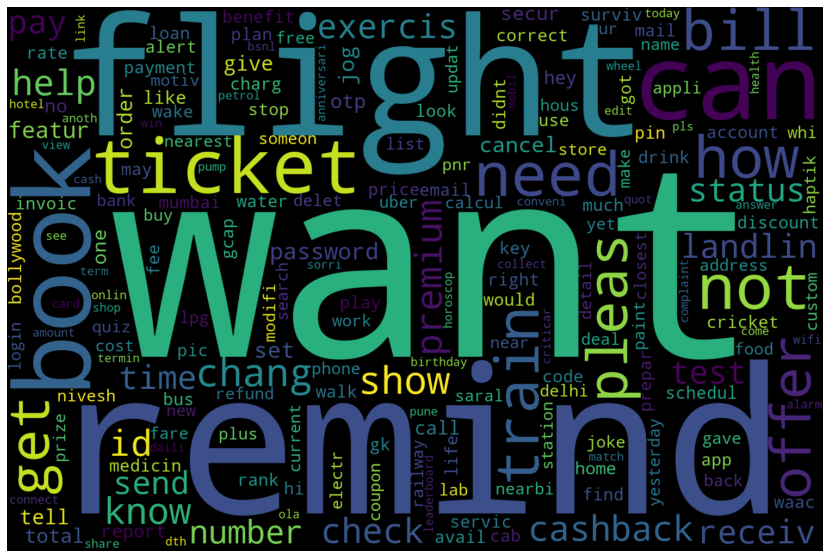

In [ ]:
freq_dict = dict()
for q1 in X_train[X_train['label'] == 1]['sentence1']:
    for word in q1.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
for q2 in X_train[X_train['label'] == 1]['sentence2']:
    for word in q2.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
feat_count_sorted = dict(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True))
count_data = {"Words":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)

worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=freq_dict)
plt.figure(figsize=(15,10))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#otp, pnr, gcap, dth, waac, id 
#should be converted into full forms


# For Non-duplicate sentences

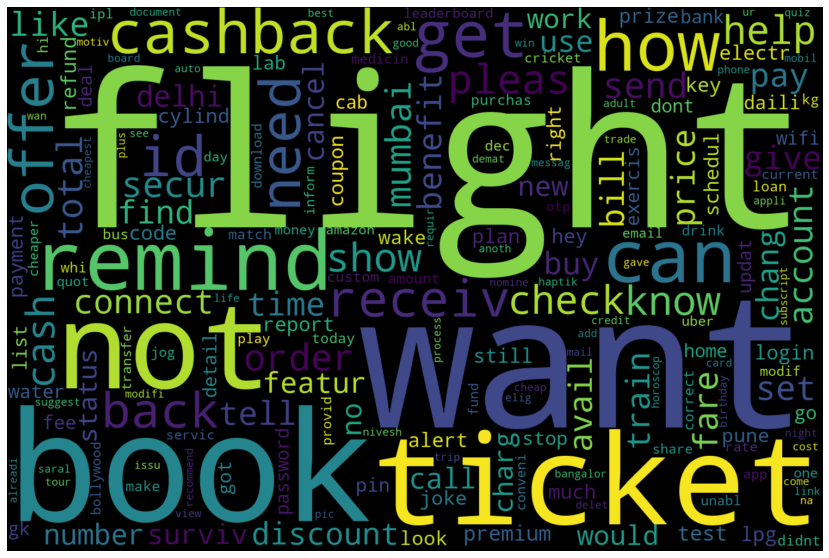

In [ ]:
#Non-duplicate sentences only
freq_dict = dict()
for q1 in X_train[X_train['label'] == 0]['sentence1']:
    for word in q1.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
for q2 in X_train[X_train['label'] == 0]['sentence2']:
    for word in q2.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
feat_count_sorted = dict(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True))
count_data = {"Words":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=freq_dict)
plt.figure(figsize=(15,10))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

# Distribution of y in train data and test data

In [ ]:
print("Distribution in train data")
print("Class 0: {}% Class 1: {}%:\n".format((y_train.value_counts()[0]/(y_train.value_counts()[0]+y_train.value_counts()[1]))*100, (y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1]))*100))


print("Distribution in test data")
print("Class 0: {}% Class 1: {}%:\n".format((y_test.value_counts()[0]/(y_test.value_counts()[0]+y_test.value_counts()[1]))*100, (y_test.value_counts()[1]/(y_test.value_counts()[0]+y_test.value_counts()[1]))*100))

Distribution in train data
Class 0: 74.1878582978098% Class 1: 25.81214170219021%:

Distribution in test data
Class 0: 74.19165196942976% Class 1: 25.808348030570254%:



In [ ]:
X_train.head()

,sentence1,sentence2,cosinesim,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
7433,feature total secure plan,premium total secure,0.577350,25,20,4,3,2.0,7.0,0.285714
14223,cancel flight,cancel,0.707107,13,6,2,1,1.0,3.0,0.333333
8488,wakeup alarm,set wake alarm,0.408248,12,14,2,3,1.0,5.0,0.200000
9135,opportunity work content department,experienced photographer looking forward work ...,0.204124,35,53,4,6,1.0,10.0,0.100000
7658,writing name grievance,want write name grievance,0.577350,22,25,3,4,2.0,7.0,0.285714


In [ ]:
#Training data--------------------------------------------------------------
X_train_feat = X_train.copy()
X_train_feat['sentence1'] = X_train_feat['sentence1'].apply(lambda row: str(row))
X_train_feat['sentence2'] = X_train_feat['sentence2'].apply(lambda row: str(row))
X_train_feat1 = X_train_feat['sentence1']
X_train_feat2 = X_train_feat['sentence2']

#Test data-------------------------------------------------------------------
X_test_feat = X_test.copy()
X_test_feat['sentence1'] = X_test_feat['sentence1'].apply(lambda row: str(row))
X_test_feat['sentence2'] = X_test_feat['sentence2'].apply(lambda row: str(row))
X_test_feat1 = X_test_feat['sentence1']
X_test_feat2 = X_test_feat['sentence2']

In [ ]:
sentences = list(X_train['sentence1']) + list(X_train['sentence2'])
tfidf = TfidfVectorizer(ngram_range=(1,3))
#tfidf.fit_transform((pd.Series(sentences)).values.astype('U'))
tfidf.fit_transform(sentences)

<27212x18436 sparse matrix of type '<class 'numpy.float64'>'
	with 187868 stored elements in Compressed Sparse Row format>

In [ ]:
print('Before Vectorization')
print('Train Question1--->',X_train_feat1.shape, y_train.shape)
print('Train Question2--->',X_train_feat2.shape, y_train.shape)

print('Test Question1--->',X_test_feat1.shape, y_test.shape)
print('Test Question1--->',X_test_feat1.shape, y_test.shape)

Before Vectorization
Train Question1---> (13606,) (13606,)
Train Question2---> (13606,) (13606,)
Test Question1---> (3402,) (3402,)
Test Question1---> (3402,) (3402,)


##Cosine similarity

In [ ]:

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# X = input("Enter first string: ").lower() 
# Y = input("Enter second string: ").lower() 
def cosim(a,b):
  X =a
  Y =b

# i have used

# # tokenization 
  X_list = word_tokenize(X)  
  Y_list = word_tokenize(Y) 
  X_list = set(X_list)
  Y_list = set(Y_list)

# sw contains the list of stopwords 
# sw = stopwords.words('english')  
  l1 =[];l2 =[] 
  
# remove stop words from the string 
# X_list = {w for w in X if not w in sw} 
# Y_list = {w for w in Y if not w in sw} 
  
# form a set containing keywords of both strings  
  rvector = X_list.union(Y_list)  
  for w in rvector:
    if w in X_list: l1.append(1) # create a vector 
    else: l1.append(0) 
    if w in Y_list: l2.append(1) 
    else: l2.append(0) 
  c = 0
  
# cosine formula  
  for i in range(len(rvector)): 
        c+= l1[i]*l2[i] 
  try:
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    print('similarity : ', cosine)
    return cosine 
  except ZeroDivisionError:
    pass 
  

,pid,sentence1,sentence2,label
0,4665,do you accept broadband bills,Broadband bill,1
1,26465,I am getting better fare for this flight,Check flight rate,0
2,57679,Flight from delhi to srinagar,check price for flight from mumbai to pune,1
3,22043,Availability of food,food available for guest,1
4,6522,This is my ID only,Can't find order ID.,0


,Unnamed: 0,pid,cosinesim,label,sentence1,sentence2
0,0,4665,0.816497,1,accept broadband bill,broadband bill
1,1,26465,0.288675,0,getting better fare flight,check flight rate
2,2,57679,0.258199,1,flight delhi srinagar,check price flight mumbai pune
3,3,22043,0.408248,1,availability food,food available guest
4,4,6522,0.447214,0,id,ca not find order id


In [ ]:

# documents = data2['sentence1']
# tfidf = TfidfVectorizer().fit_transform(documents)
# # no need to normalize, since Vectorizer will return normalized tf-idf
# pairwise_similarity = tfidf * tfidf.T

# Transforming train and test dataset

In [ ]:
X

,sentence1,sentence2,cosinesim
0,accept broadband bill,broadband bill,0.816497
1,getting better fare flight,check flight rate,0.288675
2,flight delhi srinagar,check price flight mumbai pune,0.258199
3,availability food,food available guest,0.408248
4,id,ca not find order id,0.447214
...,...,...,...
17039,want speak customer care,want speak doctor,0.577350
17040,offer currently available flight booking,offer running flight,0.516398
17041,share survival benefit,want know survival benefit saral nivesh plan,0.436436
17042,cash back not come,case back not received till,0.447214


In [ ]:
# FULL TRAIN W/O test
tfidf = TfidfVectorizer(ngram_range=(1,2))
alltext = list(X['sentence1']) + list(X['sentence2'])
tfidf.fit_transform(alltext)
Xf1 = X['sentence1']
Xf2 = X['sentence2']
# ques_len(X['sentence1'],X['sentence2'],X)#length of sentences
# nwords_ques(X['sentence1'],X['sentence2'],X)#number of words in sentences
# X['word_Common'] = X.apply(normalized_word_Common, axis=1)#total unique words in both sentence
# X['word_Total'] = X.apply(normalized_word_Total, axis=1)#total number of words
# X['word_share'] = X.apply(normalized_word_share, axis=1)#(word_common)/(word_Total)
# X.to_csv('Xtrain_fe_without_preprocessing_train.csv',index= False)
Xt1 = tfidf.transform((Xf1))
Xt2 = tfidf.transform((Xf2))
final = hstack((Xt1,Xt2))
final = hstack((final,X[['cosinesim']]))

In [ ]:
X_q1_train = tfidf.transform(X_train_feat1)
X_q2_train = tfidf.transform(X_train_feat2)

X_q1_test = tfidf.transform(X_test_feat1)
X_q2_test = tfidf.transform(X_test_feat2)

In [ ]:
print('After Vectorization')
print('Train Question1--->',X_q1_train.shape, y_train.shape)
print('Train Question2--->',X_q2_train.shape, y_train.shape)

print('='*60)
print('Test Question1--->',X_q1_test.shape, y_test.shape)
print('Test Question2--->',X_q2_test.shape, y_test.shape)

After Vectorization
Train Question1---> (13606, 18436) (13606,)
Train Question2---> (13606, 18436) (13606,)
Test Question1---> (3402, 18436) (3402,)
Test Question2---> (3402, 18436) (3402,)


In [ ]:
X_q1_train

<13635x5357 sparse matrix of type '<class 'numpy.float64'>'
	with 74897 stored elements in Compressed Sparse Row format>

##applying cosine similarity

In [ ]:
try:
  X_train['cosinesim'] = X_train.apply(lambda x: cosim(x.sentence1, x.sentence2), axis =1 )
except ZeroDivisionError as err:
  print(err)

In [ ]:
try:
  X_test['cosinesim'] = X_test.apply(lambda x: cosim(x.sentence1, x.sentence2), axis =1 )
except ZeroDivisionError as err:
  print(err)

In [ ]:
X_train.head()

,sentence1,sentence2,cosinesim,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
7433,feature total secure plan,premium total secure,0.577350,25,20,4,3,2.0,7.0,0.285714
14223,cancel flight,cancel,0.707107,13,6,2,1,1.0,3.0,0.333333
8488,wakeup alarm,set wake alarm,0.408248,12,14,2,3,1.0,5.0,0.200000
9135,opportunity work content department,experienced photographer looking forward work ...,0.204124,35,53,4,6,1.0,10.0,0.100000
7658,writing name grievance,want write name grievance,0.577350,22,25,3,4,2.0,7.0,0.285714


In [ ]:
X_train_full = hstack((X_q1_train, X_q2_train))
X_train_full = hstack((X_train_full,X_train[['cosinesim']])) 

In [ ]:
X_train_full.shape

(13606, 36873)

In [ ]:
X_test_full = hstack((X_q1_test,X_q2_test))
X_test_full = hstack((X_test_full,X_test[['cosinesim']])) 

In [ ]:
X_test_full.shape

(3402, 36873)

# 4. Machine Learning Models 

##DAT2

In [ ]:
data2 = pd.read_csv('stem.csv')

In [ ]:
data2['sentence1'] = data2.text1
data2['sentence2'] = data2.text2
data2.dropna(inplace=True)
data2.drop(['text1','text2'],1,inplace=True)

In [ ]:
X=data2[['sentence1','sentence2','cosinesim']]
y=data2['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

In [ ]:
print('Training data:' ,X_train.shape, y_train.shape)
print('Test data:    ' ,X_test.shape, y_test.shape)

Training data: (13635, 3) (13635,)
Test data:     (3409, 3) (3409,)


In [ ]:
def ques_len(sentence1,sentence2,df):
    #length of sentences
    df['q1len'] = df['sentence1'].str.len() 
    df['q2len'] = df['sentence2'].str.len()

def nwords_ques(sentence1,sentence2,df):
    #number of words in sentences
    df['q1_n_words'] = df['sentence1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['sentence2'].apply(lambda row: len(row.split(" ")))
    
def normalized_word_Common(row):
    #total unique words in both sentence
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    #total number of words
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
    
def normalized_word_share(row):
    #(word_common)/(word_Total)
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [ ]:

ques_len(X_train['sentence1'],X_train['sentence2'],X_train)#length of sentences
nwords_ques(X_train['sentence1'],X_train['sentence2'],X_train)#number of words in sentences
X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1)#total unique words in both sentence
X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1)#total number of words
X_train['word_share'] = X_train.apply(normalized_word_share, axis=1)#(word_common)/(word_Total)
X_train.to_csv('Xtrain_fe_without_preprocessing_train.csv',index= False)
X_train.head()

,sentence1,sentence2,cosinesim,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
15043,want purchase wifi,want buy wifi package,0.577350,18,21,3,4,2.0,7.0,0.285714
6452,would like book flight ticket,hi want book bus ticket,0.400000,29,23,5,5,2.0,10.0,0.200000
13980,modify medicine reminder,prepare reminder medicine,0.666667,24,25,3,3,2.0,6.0,0.333333
6346,mmt,getting ticket mmt,0.577350,3,18,1,3,1.0,4.0,0.250000
16166,recommend flight ticket,send flight timing mumbai bangalore,0.258199,23,35,3,5,1.0,8.0,0.125000


In [ ]:

ques_len(X_test['sentence1'],X_test['sentence2'],X_test)#length of sentences
nwords_ques(X_test['sentence1'],X_test['sentence2'],X_test)#number of words in sentences
X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1)#total unique words in both sentence
X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1)#total number of words
X_test['word_share'] = X_test.apply(normalized_word_share, axis=1)#(word_common)/(word_Total)
X_test.to_csv('Xtest_fe_without_preprocessing_test.csv',index= False)
X_test.head()

,sentence1,sentence2,cosinesim,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
15523,please send pic,want number,0.000000,15,11,3,2,0.0,5.0,0.000000
14658,international flight,international,0.707107,20,13,2,1,1.0,3.0,0.333333
9041,stamp duty,amount stamp duty pay,0.707107,10,21,2,4,2.0,6.0,0.333333
9860,much rate test,price test,0.408248,14,10,3,2,1.0,5.0,0.200000
1815,want invoice test,want invoice,0.816497,17,12,3,2,2.0,5.0,0.400000


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(5,3))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(5,3))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(5,3))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

xgbc = md = 6, nesti = 1000

In [ ]:
logi = XGBClassifier(max_depth=13, n_estimators=1000)

logi.fit(X_train_full,y_train)
prediction_logi = logi.predict(X_test_full)
print('classification report ', classification_report(prediction_logi,y_test))

classification report                precision    recall  f1-score   support

           0       0.96      0.92      0.94      2628
           1       0.77      0.88      0.82       774

    accuracy                           0.91      3402
   macro avg       0.87      0.90      0.88      3402
weighted avg       0.92      0.91      0.92      3402



## Applying manual hyper parameter tuning 

In [ ]:
md = [50,100,150,200]
nes = [500,1000]
for i in range(len(md)):
  for j in range(len(nes)):
    rf = RandomForestClassifier(max_depth = md[i],n_estimators = nes[j])
    rf.fit(X_train_full,y_train)
    prediction_rf = rf.predict(X_test_full)
    print('accuracy score  ', accuracy_score(prediction_rf,y_test))
    print(classification_report(prediction_rf,y_test))
    print('='*60)

accuracy score   0.8051146384479718
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3179
           1       0.25      0.98      0.40       223

    accuracy                           0.81      3402
   macro avg       0.62      0.89      0.64      3402
weighted avg       0.95      0.81      0.85      3402

accuracy score   0.8018812463256908
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3190
           1       0.24      0.98      0.38       212

    accuracy                           0.80      3402
   macro avg       0.62      0.89      0.63      3402
weighted avg       0.95      0.80      0.85      3402

accuracy score   0.8568489124044679
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2981
           1       0.46      0.96      0.63       421

    accuracy                           0.86      3402
   macro avg       0

In [ ]:
from sklearn.ensemble import StackingClassifier
rf= RandomForestClassifier(max_depth=250 , n_estimators=1000)
xg = XGBClassifier(max_depth= 15, n_estimators= 1000)
model = [('rf',rf),('xg',xg)]
stack = StackingClassifier(estimators = model)
stack.fit(X_train_full, y_train)
prediction_st = stack.predict(X_test_full)
print(classification_report(prediction_st, y_test))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2606
           1       0.80      0.88      0.84       796

    accuracy                           0.92      3402
   macro avg       0.88      0.91      0.89      3402
weighted avg       0.92      0.92      0.92      3402



In [ ]:
rf = RandomForestClassifier(max_depth=None, n_estimators=500)
# 10, 1000
rf.fit(X_train_full,y_train)
prediction_rf = rf.predict(X_test_full)
print(classification_report(prediction_rf,y_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2633
           1       0.78      0.89      0.83       769

    accuracy                           0.92      3402
   macro avg       0.87      0.91      0.89      3402
weighted avg       0.92      0.92      0.92      3402



In [ ]:
logi = XGBClassifier(max_depth=15, n_estimators=1000,learning_rate=0.1)
#with tfidf (ngram - 1,2--- mindf= 3 -----max df =1.0
#best
logi.fit(X_train_full,y_train)
prediction_logi = logi.predict(X_test_full)
print('classification report ', classification_report(prediction_logi,y_test))

classification report                precision    recall  f1-score   support

           0       0.96      0.93      0.95      2608
           1       0.79      0.88      0.83       794

    accuracy                           0.92      3402
   macro avg       0.88      0.90      0.89      3402
weighted avg       0.92      0.92      0.92      3402



In [ ]:
logi = XGBClassifier(max_depth=10, n_estimators=1000)
#ngram - 1,2

logi.fit(X_train_full,y_train)
prediction_logi = logi.predict(X_test_full)
print('classification report ', classification_report(prediction_logi,y_test))

classification report                precision    recall  f1-score   support

           0       0.97      0.92      0.94      2635
           1       0.77      0.89      0.83       767

    accuracy                           0.92      3402
   macro avg       0.87      0.90      0.88      3402
weighted avg       0.92      0.92      0.92      3402



In [ ]:
%%time
logi = XGBClassifier(max_depth=10, n_estimators=1000)
#ngram(2,3)
#low precision 1
logi.fit(X_train_full,y_train)
prediction_logi = logi.predict(X_test_full)
print('classification report ', classification_report(prediction_logi,y_test))

classification report                precision    recall  f1-score   support

           0       0.96      0.90      0.93      2694
           1       0.69      0.86      0.77       708

    accuracy                           0.89      3402
   macro avg       0.83      0.88      0.85      3402
weighted avg       0.91      0.89      0.90      3402

CPU times: user 1min 12s, sys: 45.4 ms, total: 1min 12s
Wall time: 1min 12s


In [ ]:
logi = XGBClassifier(max_depth=10, n_estimators=1000)
#no other mindf
logi.fit(X_train_full,y_train)
prediction_logi = logi.predict(X_test_full)
print('classification report ', classification_report(prediction_logi,y_test))

classification report                precision    recall  f1-score   support

           0       0.96      0.93      0.94      2620
           1       0.78      0.88      0.83       782

    accuracy                           0.91      3402
   macro avg       0.87      0.90      0.88      3402
weighted avg       0.92      0.91      0.92      3402



# TEST FILE THIS

In [ ]:
test = pd.read_csv('test.csv')


In [ ]:
test.isnull().sum()

pid          0
sentence1    0
sentence2    0
dtype: int64

In [ ]:
test


,pid,sentence1,sentence2
0,54615,As an investor how do I avail benefit with res...,Stamp Duty
1,53768,cash back nahi aaya,Muje cash back nahi mila
2,26567,LPG Storage Sytem Warranty,Is there any license required for LPG storage ...
3,4028,i want discount on flight tickets,I want discounts on train booking
4,5145,nearby bus stop,bus stop
...,...,...,...
7300,24265,Check yesterday's cricket leaderboard,Check yesterday's bollywood leaderboard
7301,49797,wana book a flight,to buy Flight Tickets
7302,14313,tell me the procedure to link aadhar to the de...,How to link my savings account to demat ?
7303,9028,"Hi, I want to check PNR status of a train .",i want to check in


In [ ]:
test['clean1'] = test['sentence1'].str.replace("@","")
test['clean1'] = test['clean1'].str.replace("#","")
test['clean1'] = test['clean1'].apply(lambda row: preprocess(row))
test['clean1'] = test['clean1'].str.replace("[^a-zA-Z]"," ")

test['clean2'] = test['sentence2'].str.replace("@","")
test['clean2'] = test['clean2'].str.replace("#","")
test['clean2'] = test['clean2'].apply(lambda row: preprocess(row))
test['clean2'] = test['clean2'].str.replace("[^a-zA-Z]"," ")


In [ ]:
# def process(sen1,sen2):
#   a= list(sen1)
#   b= list(sen2)
  
#   a = [word_tokenize(x) for x in a]
#   b = [word_tokenize(x) for x in b]
#   #a = [a for item in sublist for i in cleantext]
#   for i in range(len(a)):
#     a[i] = [x.lower() for x in a[i]]
#     a[i] = [x for x in a[i] if x not in custom]
#     a[i]  = [lemmatizer.lemmatize(y) for y in a[i]]
#     a[i] = ' '.join(a[i])


#     b[i] = [x.lower() for x in b[i]]
#     b[i] = [x for x in b[i] if x not in custom]
#     b[i]  = [lemmatizer.lemmatize(y) for y in b[i]]
#     b[i] = ' '.join(b[i])
#   return a,b
    

  

In [ ]:
text1,text2 = process(test['clean1'],test['clean2'])

In [ ]:
test['sentence1'] = text1 
test['sentence2'] = text2
test.drop(['clean1','clean2'],1,inplace= True)

In [ ]:
try:
  test['cosinesim'] = test.apply(lambda x: cosim(x.sentence1, x.sentence2), axis =1 )
except ZeroDivisionError as err:
  print(err)

In [ ]:
test.fillna(0.01, inplace=True)

In [ ]:
test_feat1 = test['sentence1']
test_feat2 = test['sentence2']

In [ ]:
test.head()


,pid,sentence1,sentence2,cosinesim
0,54615,investor avail benefit respect stamp duti,stamp duti,0.577350
1,53768,cash back nahi aaya,muje cash back nahi mila,0.670820
2,26567,lpg storag sytem warranti,licens requir lpg storag system,0.447214
3,4028,want discount flight ticket,want discount train book,0.500000
4,5145,nearbi bu stop,bu stop,0.816497


In [ ]:

ques_len(test['sentence1'],test['sentence2'],test)#length of sentences
nwords_ques(test['sentence1'],test['sentence2'],test)#number of words in sentences
test['word_Common'] = test.apply(normalized_word_Common, axis=1)#total unique words in both sentence
test['word_Total'] = test.apply(normalized_word_Total, axis=1)#total number of words
test['word_share'] = test.apply(normalized_word_share, axis=1)#(word_common)/(word_Total)
# test.to_csv('Xtest_fe_without_preprocessing_test.csv',index= False)
test.head()

NameError: ignored

In [ ]:

t1_test = tfidf.transform(test_feat1)
t2_test = tfidf.transform(test_feat2)

In [ ]:
print('After vector')

print("test 1 ---",t1_test.shape)
print("test 2 ---",t2_test.shape)

After vector
test 1 --- (7305, 18436)
test 2 --- (7305, 18436)


In [ ]:
final_tfidf = hstack((t1_test, t2_test))
final_tfidf = hstack((final_tfidf,test[['cosinesim']]))

In [ ]:
X_train_full.shape

(13606, 36873)

In [ ]:
final_tfidf.shape

(7305, 36873)

In [ ]:
final.shape

(17008, 23205)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
logi = XGBClassifier(max_depth=15, n_estimators=1000,learning_rate=0.1)
#ngram - 1,2
#best
logi.fit(final,y)
# prediction_logi = logi.predict(X_test_full)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
prediction_logi = stack.predict(final_tfidf)


In [ ]:
prediction_logi.shape

(7305,)

In [ ]:
test['label'] = prediction_logi

In [ ]:
test.head(1)

,pid,sentence1,sentence2,cosinesim,label
0,54615,investor avail benefit respect stamp duti,stamp duti,0.57735,0


In [ ]:
test[test['label']==1]

,pid,sentence1,sentence2,cosinesim,label
4,5145,nearbi bu stop,bu stop,0.816497,1
15,6768,refund,refund,1.000000,1
20,7298,calcul premium waac,need help know premium waac,0.516398,1
22,8180,not abl pull statu report,not abl pull report,0.894427,1
23,7475,visa insur,inform visa insur,0.816497,1
...,...,...,...,...,...
7286,9583,schedul remind jog,need remind exercis,0.333333,1
7290,672,want updat nomine,updat nomine,0.816497,1
7294,6255,receiv invalid otp,otp invalid,0.816497,1
7297,30936,not cancel transact,pleas cancel transact,0.666667,1


In [ ]:
for i in range(len(test)):
  if test['cosinesim'].iloc[i] == 1:
    test['label'].iloc[i] =1

In [ ]:
test[(test['label']==0)&(test['cosinesim']==1)]

,pid,sentence1,sentence2,cosinesim,label


In [ ]:
test[['pid','label']].to_csv('finaluploader69altered.csv',index=False)


In [ ]:
test.label.value_counts()


0    5636
1    1669
Name: label, dtype: int64

3.6666666666666665

In [ ]:
test.label.value_counts()


0    5677
1    1628
Name: label, dtype: int64

In [ ]:
test.label.value_counts()


0    5644
1    1661
Name: label, dtype: int64

In [ ]:
test.label.value_counts()
#finaluploader

0    5666
1    1639
Name: label, dtype: int64

In [ ]:
test.label.value_counts()
#finaluploader2

0    5640
1    1665
Name: label, dtype: int64

In [ ]:
test.label.value_counts()
#3

0    5640
1    1665
Name: label, dtype: int64